In [46]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_addons as tfa

from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow.python.ops.numpy_ops import np_config

from src.swin_transformer.model import *
from src.swin_transformer.helper import *
from src.swin_transformer.patches import *
from src.swin_transformer.window_attn import *

from src.data_prepare import preprocess_data


In [2]:
np_config.enable_numpy_behavior()

# Data errors

In [3]:
annot_df = {'img_name' : [],'classes' : [],'x' : [],'y' : [],'width' : [],'height' : []}
sample = {'image' : [],'bbox' : [],'label' : []}
empty_list = []
for idx,i in tqdm(enumerate(os.listdir('kaggle/train/labels/'))):
    ## Empty Labels
    try:
        tmp_df = pd.read_csv(f'kaggle/train/labels/{i}',header=None)
        for j in tmp_df[0].values:
            annot_df['img_name'].append(f'kaggle/train/images/{i.split(".")[0]}.png')
            #sample['image'] = Image.open(f'kaggle/train/images/{i.split(".")[0]}.png').convert('RGB')
            annot_df['classes'].append(j.split()[0])
            annot_df['x'].append(j.split()[1])
            annot_df['y'].append(j.split()[2])
            annot_df['width'].append(j.split()[3])
            annot_df['height'].append(j.split()[4])
            ###
            sample['label'].append(j.split()[0])
            sample['bbox'].append(j.split()[1])
            sample['bbox'].append(j.split()[2])
            sample['bbox'].append(j.split()[3])
            sample['bbox'].append(j.split()[4])
    except pd.errors.EmptyDataError:
        empty_list.append(i)
        continue

2474it [00:01, 1558.83it/s]


In [4]:
empty_list

['07081.txt',
 '02528.txt',
 '04966.txt',
 '06229.txt',
 '04285.txt',
 '03798.txt',
 '02448.txt']

In [12]:
df = pd.DataFrame.from_dict(annot_df)


## Plot Images

In [17]:
def plot_image(value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * image.size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * image.size[1]
        width = float(rows['width']) * image.size[0]
        height = float(rows['height']) * image.size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

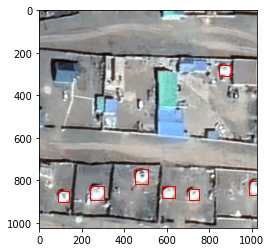

In [18]:
plot_image(0)

In [24]:
def plot_resized_image(resize_size:tuple,value=0):
    # Create figure and axes
    fig, ax = plt.subplots()

    # Load Image 
    image = Image.open(annot_df['img_name'][value])

    # Resize image
    image = tf.image.resize_with_pad(image,resize_size[0],resize_size[1])
    image = image.astype(np.uint8)

    # Load all objects
     
    tmp_df = df.query(f"img_name == '{annot_df['img_name'][value]}'")

    for idx, rows in tmp_df.iterrows():

        # Load xy, width and height
        x = (float(rows['x']) - float(rows['width']) * 0.5) * resize_size[0]
        y = (float(rows['y']) - float(rows['height']) * 0.5) * resize_size[1]
        width = float(rows['width']) * resize_size[0]
        height = float(rows['height']) * resize_size[1]
        
        # Dsiplay the image
        ax.imshow(image)

        # Create a Rectangle patch
        rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)

    plt.show()

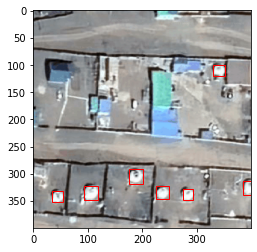

In [25]:
plot_resized_image((400,400),0)

## Prepare data

In [31]:
images = []
bbox = []
for idx, rows in tqdm(df.iterrows()):
    # Load Image 
    image = Image.open(rows['img_name'])

    # Resize image
    image = tf.image.resize_with_pad(image,32,32)
    #image = image.astype(np.uint8)
    images.append(image)

    # Append bbox
    bbox.append([rows['x'],rows['y'],rows['width'],rows['height']])

images = np.array(images)
bbox = np.array(bbox)

23455it [09:18, 42.00it/s]


In [42]:
input_shape = (32, 32, 3)
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 128  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 64
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [43]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(4, activation="sigmoid")(x)

In [44]:
model = keras.Model(input, output)

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 random_crop_3 (RandomCrop)  (None, 32, 32, 3)         0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 patch_extract_3 (PatchExtra  (None, 256, 12)          0         
 ct)                                                             
                                                                 
 patch_embedding_3 (PatchEmb  (None, 256, 64)          17216     
 edding)                                                         
                                                                 
 swin_transformer (SwinTrans  (None, 256, 64)          33560 

In [47]:
model.compile(
    loss=['mse'],
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
'mse',
    ],
)

In [48]:
model.fit(images,bbox,64,40)